### I. All the necessary imports required

In [131]:
import pandas as pd
import glob, os
import numpy as np
import csv
import pdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

### Extract and dump all the features for each of the modality
**Note: please change the two paths according to your folder location on drive**


*   data = < path to existing data folder where all folder for each modality are kept >
*   out = < path to folder where all the features is to be dumped >


In [132]:
data = 'irpev_clean'
out1 = 'C:\\Users\\Admin\\Desktop\\homework1\\hw01\\X.csv' #vid
out2 = 'C:\\Users\\Admin\\Desktop\\homework1\\hw01\\Y.csv' #gsr
out3 = 'C:\\Users\\Admin\\Desktop\\homework1\\hw01\\Z.csv' #ego

def get_statistics( arr ):
  '''
  Write a function to gather the statistics for a single participant for a particular modality

  Input:
  arr -> numpy array

  Return:
  mean, max, min, std -> all features of the respective columns in the csv
  '''

  std = np.std(arr, axis = 0) 
  mean = np.mean(arr, axis = 0)
  median = np.median(arr, axis = 0)
  mini = np.min(arr, axis = 0)
  maxi = np.max(arr, axis = 0)
  return std, mean, median, mini, maxi #returning 5 statistics 

In [133]:
def extract_features( data, dest, folder, features, common ):
  '''
  Write a function to generate all the features for each entry for each modality

  Input:
  data = path to folder where all modality folders are present
  dest = path to dump the modality features
  folder = modality name [ vid, gsr, ego ]
  features = feature columns names to give header for csv
  common = common column names to give header for csv
  '''
  cols = features + common
  with open( dest, 'w' ) as f:
    writer = csv.writer( f )
    writer.writerow( cols )

    for filepath in glob.glob( f'{data}/{folder}/*.csv' ):
      # for each entry in the modality, extract the features and dump into the csv
      # i) Extract the filename to prefix and extension (command splitext might be useful here)
      # ii) Split the prefix at '_' to find out the label 'A' or 'D'; set to 1 and 0
      # iii) Extract the data into an array from the csv file (numpy command genfromtext might be useful here )
      # iv) Call the above function get_statistics( arr ) to compute your statistics for this
        
        #Exracting the file name and setting the label
        labels = []
        label = os.path.splitext(filepath)[0][16:].split('_')[0]
        if label == 'A':
            labels.append(1)
        else:
            labels.append(0)
        
        #handling NaN values
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
        if data.ndim>1:
            data = data[~np.isnan(data).any(axis=1)]
        else:
            data = data[~np.isnan(data)]
        
        #appending labels to the statistics
        stat = get_statistics(data)
        out = np.asarray(stat)
        out = np.append(out, labels)

        if (folder == 'ego'):
            out = out.reshape(16)
        elif (folder == 'gsr'):
            out = out.reshape(6)
        else:
            out = out.reshape(11)
        
        writer.writerow(out)
        #print(out)

  print( f'Done with {folder} features' )

In [134]:
# Collect all the features from each modality and merge them; use the pandas dataframe here
res = pd.DataFrame()

col = [ 'label' ]
feat1 = [ 'engagement_std', 'contempt_std', 'engagement_mean', 'contempt_mean', 'engagement_median', 'contempt_median', 'engagement_min', 'contempt_min', 'engagement_max', 'contempt_max' ]
feat2 = [ 'cv_std', 'cv_mean', 'cv_median', 'cv_min', 'cv_max' ]
feat3 = [ 'delta_x_std', 'delta_y_std', 'delta_angle_std', 'delta_x_mean', 'delta_y_mean', 'delta_angle_mean', 'delta_x_median', 'delta_y_median', 'delta_angle_median', 'delta_x_min', 'delta_y_min', 'delta_angle_min', 'delta_x_max', 'delta_y_max', 'delta_angle_max' ]

#extracting the features
extract_features(data, out1, 'vid' , feat1, col)
extract_features(data, out2, 'gsr' , feat2, col)
extract_features(data, out3, 'ego' , feat3, col)

#reading the extracted data to a dataframe 
df1 = pd.read_csv('C:\\Users\\Admin\\Desktop\\homework1\\hw01\\X.csv')#vid
df2 = pd.read_csv('C:\\Users\\Admin\\Desktop\\homework1\\hw01\\Y.csv')#gsr
df3 = pd.read_csv('C:\\Users\\Admin\\Desktop\\homework1\\hw01\\Z.csv')#ego

#Merge the dataframes
df1['g']=df1.groupby('label').cumcount()
df2['g']=df2.groupby('label').cumcount()
df4 = df1.merge(df2,how='inner').drop('g',1)

df3['g']=df3.groupby('label').cumcount()
df4['g']=df4.groupby('label').cumcount()
res = df3.merge(df4,how='inner').drop('g',1)

#Final dataset
print(res)

print( 'Done extracting features for each modality.' )

Done with vid features
Done with gsr features
Done with ego features
    delta_x_std  delta_y_std  delta_angle_std  delta_x_mean  delta_y_mean  \
0     44.752129    57.221899         0.022471     -0.535113     -1.360479   
1    121.237963    94.091668         0.052645     -2.749699     -2.248489   
2     24.856062    40.072521         0.018938     -0.890509     -0.595821   
3     42.072886    33.195050         0.012984     -0.138158     -0.468497   
4     27.878165    41.933029         0.020332     -0.616720     -0.544618   
5     30.477958    18.264285         0.007490     -0.126608     -0.054023   
6     39.574610    55.884004         0.024555     -1.947758     -1.377723   
7     51.904826    64.673958         0.022988     -0.159605     -0.826345   
8     38.632110    38.144648         0.019351     -0.977852     -0.674107   
9     43.524129    39.200816         0.014182     -0.422797     -0.200726   
10    39.807932    59.345339         0.025164      0.068640     -1.108870   
11    1

### Now review your dataset consisting of {X, y}, then split it into training and test set with 9:1 ratio

In [135]:
# This code splits your data [X,y] into 90% training and 10%test.
features = res.columns[ ~res.columns.isin( common ) ]
X = res[ features ]
y = res[ 'label' ]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=0 )
print( f'Size -> X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}' )
 

Size -> X_train: (43, 30), X_test: (5, 30), y_train: (43,), y_test: (5,)


### Run the actual classifiers and print your performance metric(s), and confusion matrix

In [143]:
# i) Run Random Forest, report results

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Accuracy ===")
print(accuracy_score(y_test, rfc_predict)*100)
print('\n')
print("=== Classification Report ===")
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print("StdDeviation AUC Score - Random Forest: ", rfc_cv_score.std())

=== Confusion Matrix ===
[[4 0]
 [0 1]]


=== Accuracy ===
100.0


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9
StdDeviation AUC Score - Random Forest:  0.1699673171197595


In [137]:
# ii) Run SVM (remember there can be multiple kernels, just one is fine), report results

clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X_train,y_train)
clf_predict = clf.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, clf_predict))
print('\n')
print("=== Accuracy ===")
print(accuracy_score(y_test, clf_predict)*100)
print('\n')
print("=== Classification Report ===")
clf_cv_score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
print(classification_report(y_test, clf_predict))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - SVM: ", clf_cv_score.mean())
print("StdDeviation AUC Score - SVM: ", clf_cv_score.std())

=== Confusion Matrix ===
[[3 1]
 [0 1]]


=== Accuracy ===
80.0


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5



=== Mean AUC Score ===
Mean AUC Score - SVM:  0.8666666666666668
StdDeviation AUC Score - SVM:  0.17950549357115014


In [141]:
# iii) Run a Neural Network classifier, report results

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=10000)
mlp.fit(X_train,y_train)
mlp_predict = mlp.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, mlp_predict))
print('\n')
print("=== Accuracy ===")
print(accuracy_score(y_test, mlp_predict)*100)
print('\n')
print("=== Classification Report ===")
mlp_cv_score = cross_val_score(mlp, X, y, cv=10, scoring='roc_auc')
print(classification_report(y_test, mlp_predict))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Neural Net: ", mlp_cv_score.mean())
print("StdDeviation AUC Score - Neural Net: ", mlp_cv_score.std())


=== Confusion Matrix ===
[[2 2]
 [0 1]]


=== Accuracy ===
60.0


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         4
         1.0       0.33      1.00      0.50         1

    accuracy                           0.60         5
   macro avg       0.67      0.75      0.58         5
weighted avg       0.87      0.60      0.63         5



=== Mean AUC Score ===
Mean AUC Score - Neural Net:  0.5916666666666667
StdDeviation AUC Score - Neural Net:  0.3215630230262456


=== Confusion Matrix ===
[[4 0]
 [0 1]]


=== Accuracy ===
100.0


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9166666666666666
StdDeviation AUC Score - XGBoost:  0.13437096247164246


<AxesSubplot:>

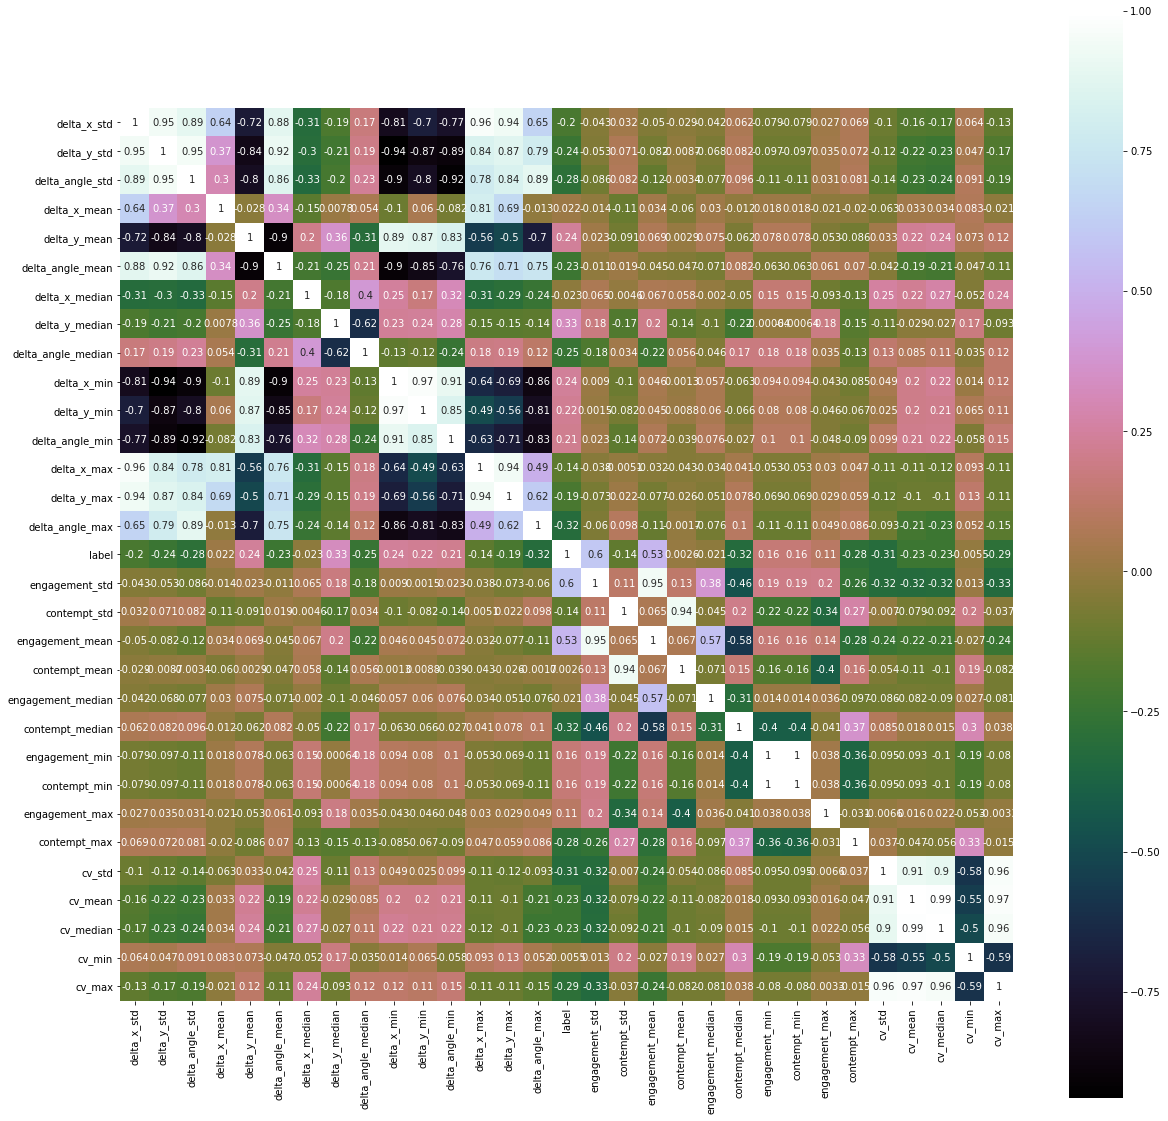

In [139]:
# iv) BONUS: Run and report on a fourth classifier of your choice that performs better than the 3 above
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)
xgb_predict = xgb.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, xgb_predict))
print('\n')
print("=== Accuracy ===")
print(accuracy_score(y_test, xgb_predict)*100)
print('\n')
print("=== Classification Report ===")
xgb_cv_score = cross_val_score(xgb, X, y, cv=10, scoring='roc_auc')
print(classification_report(y_test, xgb_predict))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", xgb_cv_score.mean())
print("StdDeviation AUC Score - XGBoost: ", xgb_cv_score.std())

#We can also use a correlation matrix to obtain the features which have a strong positive relation(tending to 1) with label
#to help us reduce the bias.
plt.figure(figsize=(20,20))
sns.heatmap(res.corr(),vmax=1, square=True,annot=True,cmap='cubehelix',xticklabels=True,yticklabels=True)